# model_A.ipynb
Author: Connacher Murphy

See documentation for a discussion of this implementation.

## 0. Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qsm_calibration as qsmc

## 1. Calibration
We create the commuting flows matrix $\mathbf{\pi}$, where $\pi_{i n}$ denotes the share of workers living in neighborhood $i$ commuting to neighborhood $n$.

In [61]:
( # calibrate() returns objects needed for models A and B
    pi,
    pi_cond,
    residents,
    workers,
    R_bar,
    wages,
    num_nbhd,
    far_southeast_indices,
    employment_core_indices,
    neighborhoods_shp,
    theta,
    alpha,
    beta,
) = qsmc.calibrate()

## 2. Counterfactual solver
Following the notation in the writeup, I let $i$ correspond to the first index and $n$ to the second.

In [62]:
# Define component functions for counterfactual solver
def calc_real_wage_hat(w_hat, kappa_hat):
    """
    Calculate changes in real wages
    Arguments:
        w_hat: wage changes
        kappa_hat: commuting cost changes
    """
    return w_hat / kappa_hat


def calc_sub_phi_hat(theta, w_hat, kappa_hat):
    """
    Scale the changes in real wages by theta
    Arguments:
        theta: preference shock dispersion parameter
        w_hat: wage changes
        kappa_hat: commuting cost changes
    """
    real_wage_hat = calc_real_wage_hat(w_hat, kappa_hat)
    return np.power(real_wage_hat, theta)


def calc_Phi_hat(theta, pi_cond_init, w_hat, kappa_hat):
    """
    Calculate Phi_hat
    Arguments:
        theta: preference shock dispersion parameter
        pi_cond_init: conditional commuting probabilities
        w_hat: wage changes
        kappa_hat: commuting cost changes
    """
    sub_phi_hat = calc_sub_phi_hat(theta, w_hat, kappa_hat)
    return np.sum(pi_cond_init * sub_phi_hat, axis=1, keepdims=True)


def calc_pi_hat(theta, pi_cond_init, w_hat, kappa_hat):
    """
    Calculate pi_hat
    Arguments:
        theta: preference shock dispersion parameter
        pi_cond_init: conditional commuting probabilities
        w_hat: wage changes
        kappa_hat: commuting cost changes
    """
    # real_wage_hat = calc_real_wage_hat(w_hat, kappa_hat)
    # sub_phi_hat = calc_real_wage_hat_scale(theta, real_wage_hat)
    sub_phi_hat = calc_sub_phi_hat(theta, w_hat, kappa_hat)
    Phi_hat = calc_Phi_hat(theta, pi_cond_init, w_hat, kappa_hat)

    return sub_phi_hat / Phi_hat


def calc_Z(w_tilde, theta, beta, pi_init, R_init, L_init, A_hat, kappa_hat, R_hat):
    """
    Calculate calligraphic Z for candidate wage changes
    Arguments:
        w_tilde: candidate wage changes
        theta: preference shock dispersion parameter
        beta: elasticity of output with respect to labor
        pi_cond_init: conditional commuting probabilities
        R_init: initial residential population
        L_init: initial workplace population
        A_hat: productivity changes
        kappa_hat: commuting cost changes
        R_hat: residential population changes
    """

    demand_term = np.power(A_hat / w_tilde, 1 / (1 - alpha))

    pi_hat = calc_pi_hat(theta, pi_init, w_tilde, kappa_hat)

    supply_term = (
        np.sum(pi_init * R_init * pi_hat * R_hat, axis=0, keepdims=True) / L_init
    )

    return demand_term - supply_term

In [63]:
# Unit test
# calc_Z should return all zeros if we guess the correct wage changes
# We can set all parameter proportional changes to 1 (no changes) and check
# that a vector of unchanged wages is an equilibrium
w_tilde = np.ones((1, num_nbhd)) # use the second index to follow tilde(w)_n notation
A_hat = np.ones((1, num_nbhd))
R_hat = np.ones((num_nbhd, 1))
kappa_hat = np.ones((num_nbhd, num_nbhd))

Z = calc_Z(w_tilde, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat)

print(f"Maximum absolute value of Z_i: {abs(Z).max()}")

print("Checking for nan values:")
print(f"Z: {np.sum(np.isnan(Z))}")

Maximum absolute value of Z_i: 1.1102230246251565e-16
Checking for nan values:
Z: 0


In [64]:
def solve_counterfactual(
    num_nbhd, theta, alpha, pi_init, R_init, L_init, A_hat, kappa_hat, R_hat
):
    w_tilde = np.ones((1, num_nbhd))  # initial guess for wage changes
    i = 0  # iteration counter
    error = 1.0  # initialize error
    tol = 1e-10  # error tolerance
    kappa = 0.1  # step size

    while error > tol:  # iterate until error is below tolerance
        Z = calc_Z(
            w_tilde, theta, alpha, pi_init, R_init, L_init, A_hat, kappa_hat, R_hat
        )

        w_tilde = w_tilde + (Z * kappa)  # update wage

        error = np.absolute(Z).max()  # calculate error
        print("Step", i, "error:", round(error, 10))
        i += 1

    return w_tilde

In [65]:
# Run the unit test again, using the solve_counterfactual() function
w_hat = solve_counterfactual(
    num_nbhd, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat
)

print(f"Maximum absolute value of w_hat - 1: {abs(w_hat - 1).max()}")

print("Checking for nan values:")
print(f"w_hat: {np.sum(np.isnan(w_hat))}")

Step 0 error: 0.0
Maximum absolute value of w_hat - 1: 0.0
Checking for nan values:
w_hat: 0


In [66]:
def summarize_counterfactual(num_nbhd, neighborhoods_shp, w_hat, A_hat):
    df_hat = pd.DataFrame(  # stack wage and productivity changes into df
        np.column_stack(
            (
                w_hat.reshape((num_nbhd)),
                A_hat.reshape((num_nbhd)),
            )
        ),
        columns=["w_hat", "A_hat"],
    )

    df_hat["id"] = df_hat.index + 1

    df_hat_shp = neighborhoods_shp.merge(  # merge with shapefile
        df_hat, on="id"
    )

    return df_hat_shp

## 3. Counterfactual exercises

### 3.i. Local productivity shock

In [67]:
print("Local productivity shock in far southeast")

A_hat[:, far_southeast_indices] = 1.05  # increase productivity by 5% in far southeast
w_hat = solve_counterfactual(
    num_nbhd, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat
)

productivity_shock_shp = summarize_counterfactual(
    num_nbhd, neighborhoods_shp, w_hat, A_hat
)

Local productivity shock in far southeast
Step 0 error: 0.1297263219
Step 1 error: 0.0603006826
Step 2 error: 0.0285251139
Step 3 error: 0.0136829422
Step 4 error: 0.0066695423
Step 5 error: 0.0033224206
Step 6 error: 0.0017055958
Step 7 error: 0.0009111593
Step 8 error: 0.0005111351
Step 9 error: 0.0003027803
Step 10 error: 0.000189409
Step 11 error: 0.0001244453
Step 12 error: 8.51049e-05
Step 13 error: 5.99853e-05
Step 14 error: 4.31953e-05
Step 15 error: 3.15603e-05
Step 16 error: 2.32813e-05
Step 17 error: 1.73058e-05
Step 18 error: 1.29525e-05
Step 19 error: 9.702e-06
Step 20 error: 7.2711e-06
Step 21 error: 5.4512e-06
Step 22 error: 4.0878e-06
Step 23 error: 3.0658e-06
Step 24 error: 2.2996e-06
Step 25 error: 1.725e-06
Step 26 error: 1.2941e-06
Step 27 error: 9.708e-07
Step 28 error: 7.283e-07
Step 29 error: 5.464e-07
Step 30 error: 4.099e-07
Step 31 error: 3.075e-07
Step 32 error: 2.307e-07
Step 33 error: 1.731e-07
Step 34 error: 1.299e-07
Step 35 error: 9.74e-08
Step 36 error:

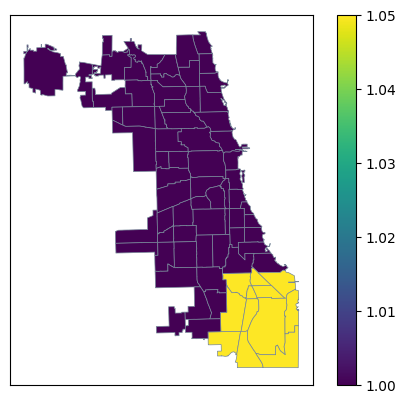

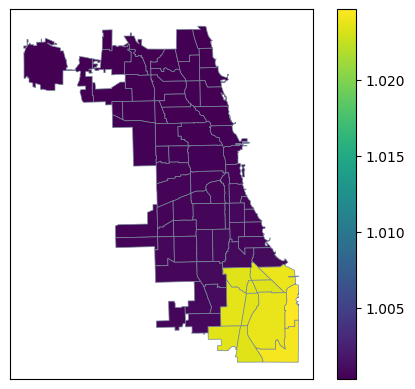

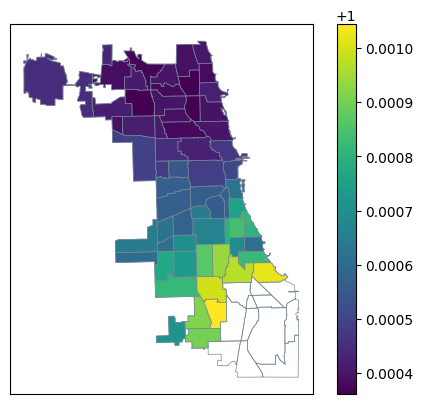

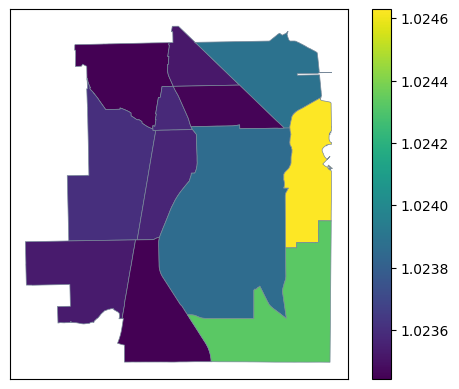

In [68]:
# Summarize results
figsize = (10, 10)

# A_hat
productivity_shock_shp.plot(
    column='A_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
# plt.title('$\\hat{A}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_A_hat.png')
plt.show()

# w_hat (all neighborhoods)
productivity_shock_shp.plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat.png')
plt.show()

# w_hat (exclude far southeast)
fig, ax = plt.subplots()

# Full boundaries
productivity_shock_shp.plot(
    facecolor='none', edgecolor='lightslategray', linewidth=0.5, ax=ax
)
# Exclude far southeast
productivity_shock_shp[productivity_shock_shp['far_southeast'] == 0].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5, ax=ax
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_censor.png')
plt.show()

# w_hat (only far southeast)
productivity_shock_shp[productivity_shock_shp['far_southeast'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_focus.png')
plt.show()

### 3.ii. Employment core transportation shock

In [69]:
# Reset A_hat
A_hat = np.ones((1, num_nbhd))

# Reduce travel costs from far Southeast to employment core by 5%
kappa_hat[far_southeast_indices.reshape(-1, 1), employment_core_indices] = 0.95

w_hat = solve_counterfactual(
    num_nbhd, theta, alpha, pi, residents, workers, A_hat, kappa_hat, R_hat
)
transport_shock_shp = summarize_counterfactual(num_nbhd, neighborhoods_shp, w_hat, A_hat)

Step 0 error: 0.0495757552
Step 1 error: 0.0245300949
Step 2 error: 0.0121813999
Step 3 error: 0.006059862
Step 4 error: 0.0030174599
Step 5 error: 0.0015034772
Step 6 error: 0.0007495687
Step 7 error: 0.0003739799
Step 8 error: 0.0001867853
Step 9 error: 9.34358e-05
Step 10 error: 4.68481e-05
Step 11 error: 2.35703e-05
Step 12 error: 1.1919e-05
Step 13 error: 6.0719e-06
Step 14 error: 3.1261e-06
Step 15 error: 1.6336e-06
Step 16 error: 8.711e-07
Step 17 error: 4.77e-07
Step 18 error: 2.699e-07
Step 19 error: 1.587e-07
Step 20 error: 9.72e-08
Step 21 error: 6.2e-08
Step 22 error: 4.11e-08
Step 23 error: 2.81e-08
Step 24 error: 1.98e-08
Step 25 error: 1.41e-08
Step 26 error: 1.03e-08
Step 27 error: 7.5e-09
Step 28 error: 5.6e-09
Step 29 error: 4.1e-09
Step 30 error: 3.1e-09
Step 31 error: 2.3e-09
Step 32 error: 1.7e-09
Step 33 error: 1.3e-09
Step 34 error: 1e-09
Step 35 error: 7e-10
Step 36 error: 5e-10
Step 37 error: 4e-10
Step 38 error: 3e-10
Step 39 error: 2e-10
Step 40 error: 2e-10


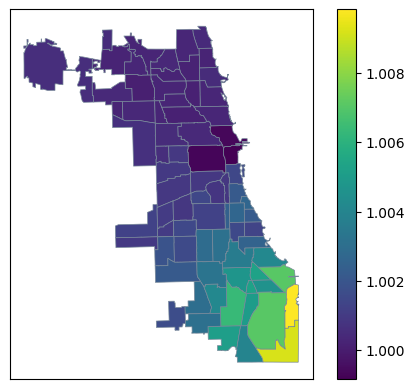

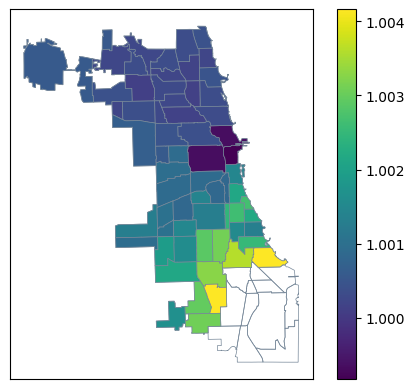

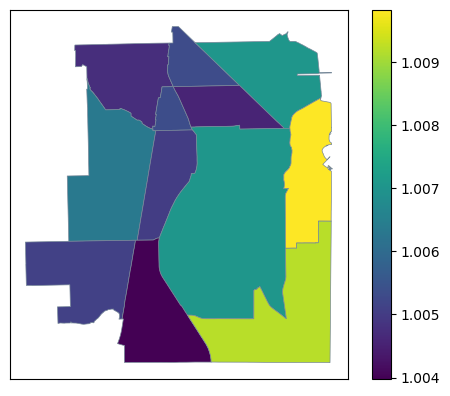

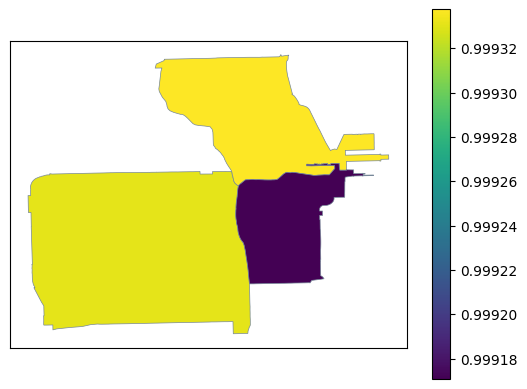

In [70]:
# w_hat (all neighborhoods)
transport_shock_shp.plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat.png')
plt.show()

# w_hat (exclude far southeast)
fig, ax = plt.subplots()

# Full boundaries
transport_shock_shp.plot(
    facecolor='none', edgecolor='lightslategray', linewidth=0.5, ax=ax
)
# Exclude far southeast
transport_shock_shp[productivity_shock_shp['far_southeast'] == 0].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5, ax=ax
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_censor.png')
plt.show()

# w_hat (only far southeast)
transport_shock_shp[transport_shock_shp['far_southeast'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/productivity_shock_w_hat_focus.png')
plt.show()

# w_hat (only loop)
transport_shock_shp[transport_shock_shp['employment_core'] == 1].plot(
    column='w_hat', legend=True, edgecolor='lightslategray', linewidth=0.5
)
plt.xticks([])
plt.yticks([])
plt.savefig('../out/transport_shock_w_hat_focus_core.png')
plt.show()